In [109]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from skimage import transform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding

def convnet_model_():
    vgg_model = VGG16(weights=None, include_top=False)
    x = vgg_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Lambda(lambda  x_: K.l2_normalize(x,axis=1))(x)
    convnet_model = Model(inputs=vgg_model.input, outputs=x)
    return convnet_model

def deep_rank_model():
 
    convnet_model = convnet_model_()
    first_input = Input(shape=(224,224,3))
    first_conv = Conv2D(96, kernel_size=(8, 8),strides=(16,16), padding='same')(first_input)
    first_max = MaxPool2D(pool_size=(3,3),strides = (4,4),padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = Lambda(lambda  x: K.l2_normalize(x,axis=1))(first_max)

    second_input = Input(shape=(224,224,3))
    second_conv = Conv2D(96, kernel_size=(8, 8),strides=(32,32), padding='same')(second_input)
    second_max = MaxPool2D(pool_size=(7,7),strides = (2,2),padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = Lambda(lambda  x: K.l2_normalize(x,axis=1))(second_max)

    merge_one = concatenate([first_max, second_max])

    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(4096)(merge_two)
    l2_norm_final = Lambda(lambda  x: K.l2_normalize(x,axis=1))(emb)

    final_model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    return final_model


model = deep_rank_model()
model.load_weights('deepranking.h5')
# for layer in model.layers:
#     print (layer.name, layer.output_shape)



In [110]:
import os
dir='img2'
sub_dir= list(os.walk(dir))[0][1]
print(sub_dir)
len(sub_dir)
import glob
img_dict={}
for i in sub_dir:
        temp=glob.glob(dir+'/'+i+"/*.jpg")
        if (len(temp)>20):
            temp=temp[0:20]
        else:
            pass
        img_dict[i]=temp

label=list(img_dict.keys())

['Crochet_Woven_Blouse', 'Cuffed-Sleeve_Knit_Blazer', 'Drawstring_Chino_Shorts', 'Embroidered_Peasant_Blouse', 'Classic_Knit_Leggings', 'Classic_Heathered_Tee', 'Knit_Pocket_Dress', 'Classic_Knit_Pencil_Skirt', 'L.A.T.H.C._Victory_Circle_Tee', 'Classic_Cotton_Tank', 'Knit_Romper', 'Classic_Halter_Top', 'Cutout_Muscle_Tee', 'Definition_of_Love_Tee', 'Knit_Crew_Neck_Sweater', 'Knit_Skater_Skirt', 'Dotted_Tulle_Maxi_Skirt']


In [111]:
len(img_dict.keys())

17

In [112]:
import pandas as pd

In [113]:
temp_img=[]
temp_label=[]
temp_id=[]
t=0
for i in img_dict.keys():
    for j in img_dict[i]:
        temp_img.append(j)
        temp_label.append(i)
        temp_id.append(t)
        t=t+1

data= pd.DataFrame({'id':temp_id,'img':temp_img,'label':temp_label})        

In [114]:
data.head()

,id,img,label
0,0,img2/Crochet_Woven_Blouse/img_00000059.jpg,Crochet_Woven_Blouse
1,1,img2/Crochet_Woven_Blouse/img_00000076.jpg,Crochet_Woven_Blouse
2,2,img2/Crochet_Woven_Blouse/img_00000013.jpg,Crochet_Woven_Blouse
3,3,img2/Crochet_Woven_Blouse/img_00000011.jpg,Crochet_Woven_Blouse
4,4,img2/Crochet_Woven_Blouse/img_00000006.jpg,Crochet_Woven_Blouse


In [115]:
temp_vector=[]
for i in data['img']:
    image = load_img(i)
    image = img_to_array(image).astype("float64")
    image = transform.resize(image, (224, 224))
    image *= 1. / 255
    image = np.expand_dims(image, axis = 0)
    embedding = model.predict([image, image, image])[0]
    temp_vector.append(embedding)
    

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [117]:
for i in range (len(temp_vector)):
    temp_vector[i] = temp_vector[i].tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [118]:
type(temp_vector[0])

list

In [119]:
data['vector'] = temp_vector
data.head()

,id,img,label,vector
0,0,img2/Crochet_Woven_Blouse/img_00000059.jpg,Crochet_Woven_Blouse,"[-0.0018834855873137712, 0.007752628996968269,..."
1,1,img2/Crochet_Woven_Blouse/img_00000076.jpg,Crochet_Woven_Blouse,"[-0.005079860799014568, 0.005608389154076576, ..."
2,2,img2/Crochet_Woven_Blouse/img_00000013.jpg,Crochet_Woven_Blouse,"[0.006581147201359272, 0.013708801008760929, -..."
3,3,img2/Crochet_Woven_Blouse/img_00000011.jpg,Crochet_Woven_Blouse,"[-0.001058132853358984, 0.004487413447350264, ..."
4,4,img2/Crochet_Woven_Blouse/img_00000006.jpg,Crochet_Woven_Blouse,"[-0.00343622756190598, 0.004875160753726959, 0..."


In [120]:
data.to_csv('record.csv')
print('done')

done


In [121]:
data['vector'][0]

[-0.0018834855873137712,
 0.007752628996968269,
 0.003992373123764992,
 0.027225181460380554,
 -0.006366782356053591,
 0.009711096063256264,
 0.0016261124983429909,
 0.01088152639567852,
 -0.006554314401000738,
 -0.0012805494479835033,
 -0.0016663703136146069,
 -0.0033525610342621803,
 -0.003874668851494789,
 0.007381973322480917,
 -0.0013709760969504714,
 -0.006185442674905062,
 -0.00985058955848217,
 0.026296865195035934,
 0.010299882851541042,
 -0.006138043012470007,
 0.020000962540507317,
 0.001591306645423174,
 -0.003612541127949953,
 -0.005456922110170126,
 0.0063741691410541534,
 -0.0006495247944258153,
 0.0034124511294066906,
 0.017906632274389267,
 0.006272482220083475,
 0.005195298232138157,
 0.0019860342144966125,
 -0.0036567996721714735,
 -0.007813934236764908,
 0.032406628131866455,
 -0.0032923100516200066,
 0.014090546406805515,
 0.011873229406774044,
 0.014054358936846256,
 -0.013833248056471348,
 -0.007363744545727968,
 0.024472730234265327,
 0.00013953643792774528,
 0.

In [36]:
!pip install annoy

    100% |████████████████████████████████| 645kB 31.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for annoy ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/9a/61/5c/2a83890a4531ed5177d6df7f667539316aa65a573cb4d44d71
Successfully built annoy
tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 3.0.2 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [123]:
import os
import csv
import json
import requests
import datetime
import string
import decimal
import re
from multiprocessing.dummy import Pool as ThreadPool
import concurrent.futures
from random import shuffle
import random
import numpy as np
import pandas as pd
import pickle
import sys
from annoy import AnnoyIndex


def _index_and_search(k,target):
    xb = []                # array to be indexed
    xb = list(data['vector'])

    d = 4096
    nb = len(xb)                 # database size
    nq = 1                      # nb of queries
    annoy_index(d, xb)
    # print("End Indexing"+str(datetime.datetime.now()))

    xq = 0
    query_vector=target

    try:
        xq = xb.index(query_vector)
        # print("Start Searching"+str(datetime.datetime.now()))
        I = annoy_search(xq, 'annoy_index.ann', k, d) # search results
        # print("End Searching"+str(datetime.datetime.now()))
        # return {"I":I}
        return explain_result(I)
    except Exception as e:
        raise
        return {"message":"query_id not found in index"}

def get_value_for_key(key, object):
    if key in object:
        return object[key]
    else:
        return ""

def annoy_index(d, xb):
    t = AnnoyIndex(d)  # Length of item vector that will be indexed
    for i, x in enumerate(xb):
        t.add_item(i, x)

    t.build(20) # 10 trees
    t.save('annoy_index.ann')

def annoy_search(xq, index, k, d):
    u = AnnoyIndex(d)
    u.load(index) # super fast, will just mmap the file
    I = u.get_nns_by_item(xq, k)
    return I

def explain_result(I):
    print(I)


    return {"message": I}

In [124]:
p= _index_and_search(25,data['vector'][50])
print(p)

[50, 324, 43, 140, 61, 283, 195, 57, 120, 187, 132, 98, 112, 229, 233, 128, 134, 95, 185, 145, 137, 58, 277, 127, 252]
{'message': [50, 324, 43, 140, 61, 283, 195, 57, 120, 187, 132, 98, 112, 229, 233, 128, 134, 95, 185, 145, 137, 58, 277, 127, 252]}


In [125]:
output=p['message']
output

[50,
 324,
 43,
 140,
 61,
 283,
 195,
 57,
 120,
 187,
 132,
 98,
 112,
 229,
 233,
 128,
 134,
 95,
 185,
 145,
 137,
 58,
 277,
 127,
 252]

In [126]:
similar_image=[]
similar_label=[]
for i in range (len(output)):
    similar_image.append(list(data.loc[data['id']==output[i]]['img'])[0])
    similar_label.append(list(data.loc[data['id']==output[0]]['label'])[0])

In [127]:
similar_label

['Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts',
 'Drawstring_Chino_Shorts']

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


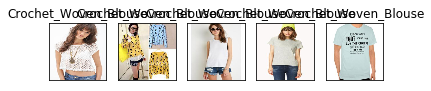

In [107]:
# from scipy.misc import imresize
# import itertools
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline

# def show_img(sid, img_file, img_title):
#     plt.subplot(sid)
#     plt.title(img_title)
#     plt.xticks([])
#     plt.yticks([])
#     img = imresize(plt.imread(img_file), (2084, 2084))
#     plt.imshow(img)


# r=1
# c='5' 
# t=0
# for i in range (25):
#     t=t+1
    
#     if(r>5):
#         r=1
#     else:
#         pass
#     if(t>5):
#         t=1
#     else:
#         pass
#     show_img(int(str(r)+c+str(t)), similar_image[i],similar_label[i])
    



# plt.tight_layout()
# plt.show()

Populating the interactive namespace from numpy and matplotlib


TypeError: Image data cannot be converted to float

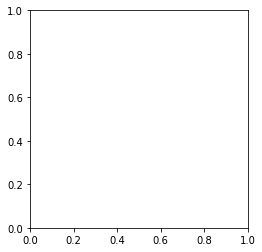

In [130]:
from matplotlib import pyplot as plt
%pylab inline
plt.imshow(similar_image[0],cmap='gray')
plt.show()

In [12]:
image1 = load_img('img2/Classic_Cotton_Tank/img_00000001.jpg')
image1 = img_to_array(image1).astype("float64")
image1 = transform.resize(image1, (224, 224))
image1 *= 1. / 255
image1 = np.expand_dims(image1, axis = 0)

embedding1 = model.predict([image1, image1, image1])[0]

image2 = load_img('img2/Classic_Cotton_Tank/img_00000005.jpg')
image2 = img_to_array(image2).astype("float64")
image2 = transform.resize(image2, (224, 224))
image2 *= 1. / 255
image2 = np.expand_dims(image2, axis = 0)

embedding2 = model.predict([image2,image2,image2])[0]
print(embedding2)

distance = sum([(embedding1[idx] - embedding2[idx])**2 for idx in range(len(embedding1))])**(0.5)

print (distance)


[-0.00398563  0.00576871  0.00227091 ...  0.00163697 -0.00196341
  0.01133402]
0.20094847278079161
